In [4]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Reconstructions.ipynb --to python"
# call(command,shell=True)

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

device: cuda


/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = "--data_path=/root/autodl-tmp/NSD \
                    --subj=1 \
                    --img2img_strength 0.85 \
                    --autoencoder_name=autoencoder_subj01_4x_locont_no_reconst\
                    --model_name=baseline"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)

['--data_path=/root/autodl-tmp/NSD', '--subj=1', '--img2img_strength', '0.85', '--autoencoder_name=autoencoder_subj01_4x_locont_no_reconst', '--model_name=baseline']


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of trained model",
)
parser.add_argument(
    "--autoencoder_name", type=str, default="None",
    help="name of trained autoencoder model",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-medarc/fmri/natural-scenes-dataset",
    help="Path to where NSD data is stored (see README)",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--img2img_strength",type=float, default=.85,
    help="How much img2img (1=no img2img; 0=outputting the low-level image itself)",
)
parser.add_argument(
    "--recons_per_sample", type=int, default=1,
    help="How many recons to output, to then automatically pick the best one (MindEye uses 16)",
)
parser.add_argument(
    "--vd_cache_dir", type=str, default='/root/autodl-tmp/vd/models--shi-labs--versatile-diffusion/snapshots/2926f8e11ea526b562cd592b099fcf9c2985d0b7',
    help="Where is cached Versatile Diffusion model; if not cached will download to this path",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
if autoencoder_name=="None":
    autoencoder_name = None

In [4]:
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


In [5]:
val_url = f"{data_path}/test/test_subj0{subj}_" + "{0..1}.tar"
meta_url = f"{data_path}/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = val_batch_size = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])


## Load autoencoder

In [6]:
from models import Voxel2StableDiffusionModel

outdir = f'/root/autodl-fs/fMRI/train_logs/{autoencoder_name}'
ckpt_path = os.path.join(outdir, f'epoch120.pth')

if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    voxel2sd = Voxel2StableDiffusionModel(in_dim=num_voxels)

    voxel2sd.load_state_dict(state_dict,strict=False)
    voxel2sd.eval()
    voxel2sd.to(device)
    print("Loaded low-level model!")
else:
    print("No valid path for low-level model specified; not using img2img!") 
    img2img_strength = 1

Loaded low-level model!


# Load VD pipe

In [7]:
print('Creating versatile diffusion reconstruction pipeline...')
from diffusers import VersatileDiffusionDualGuidedPipeline, UniPCMultistepScheduler
from diffusers.models import DualTransformer2DModel
try:
    vd_pipe =  VersatileDiffusionDualGuidedPipeline.from_pretrained(vd_cache_dir).to(device).to(torch.float16)
except:
    print("Downloading Versatile Diffusion to", vd_cache_dir)
    vd_pipe =  VersatileDiffusionDualGuidedPipeline.from_pretrained(
            "shi-labs/versatile-diffusion",
            cache_dir = vd_cache_dir).to(device).to(torch.float16)
    
vd_pipe.image_unet.eval()
vd_pipe.vae.eval()
vd_pipe.image_unet.requires_grad_(False)
vd_pipe.vae.requires_grad_(False)

vd_pipe.scheduler = UniPCMultistepScheduler.from_pretrained(vd_cache_dir, subfolder="scheduler")
num_inference_steps = 20

# Set weighting of Dual-Guidance 
text_image_ratio = .0 # .5 means equally weight text and image, 0 means use only image
for name, module in vd_pipe.image_unet.named_modules():
    if isinstance(module, DualTransformer2DModel):
        module.mix_ratio = text_image_ratio
        for i, type in enumerate(("text", "image")):
            if type == "text":
                module.condition_lengths[i] = 77
                module.transformer_index_for_condition[i] = 1  # use the second (text) transformer
            else:
                module.condition_lengths[i] = 257
                module.transformer_index_for_condition[i] = 0  # use the first (image) transformer

unet = vd_pipe.image_unet
vae = vd_pipe.vae
noise_scheduler = vd_pipe.scheduler

Creating versatile diffusion reconstruction pipeline...


/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Load Versatile Diffusion model

In [8]:
img_variations = False

out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100 #100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    )

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
)

outdir = f'/root/autodl-tmp/fMRI/train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

ViT-L/14 cuda
ckpt_path /root/autodl-tmp/fMRI/train_logs/baseline/last.pth
EPOCH:  149


## Load Image Variations model

In [9]:
# img_variations = True

# # CLS model
# out_dim = 768
# clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=False, device=device)
# voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
# voxel2clip = BrainNetwork(**voxel2clip_kwargs)
# voxel2clip.requires_grad_(False)
# voxel2clip.eval()

# diffusion_prior = BrainDiffusionPriorOld.from_pretrained(
#     # kwargs for DiffusionPriorNetwork
#     dict(),
#     # kwargs for DiffusionNetwork
#     dict(
#         condition_on_text_encodings=False,
#         timesteps=1000,
#         voxel2clip=voxel2clip,
#     ),
#     voxel2clip_path=None,
# )

# outdir = f'../train_logs/{model_name}'
# ckpt_path = os.path.join(outdir, f'last.pth')

# print("ckpt_path",ckpt_path)
# checkpoint = torch.load(ckpt_path, map_location=device)
# state_dict = checkpoint['model_state_dict']
# print("EPOCH: ",checkpoint['epoch'])
# diffusion_prior.load_state_dict(state_dict,strict=False)
# diffusion_prior.eval().to(device)
# diffusion_priors = [diffusion_prior]
# pass

In [10]:
# from diffusers import AutoencoderKL, UNet2DConditionModel, UniPCMultistepScheduler

# sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
# unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet").to(device)

# unet.eval() # dont want to train model
# unet.requires_grad_(False) # dont need to calculate gradients

# vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
# vae.eval()
# vae.requires_grad_(False)

# noise_scheduler = UniPCMultistepScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
# num_inference_steps = 20

# Reconstruct one-at-a-time

2024-01-26 12:23:15


  0%|          | 0/982 [00:00<?, ?it/s]

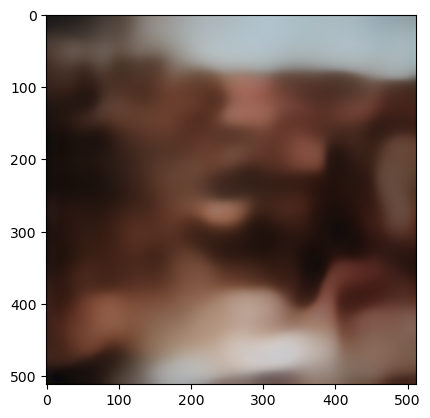

/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████▉| 981/982 [40:00<00:02,  2.45s/it]


2024-01-26 13:03:16
recon_path: baseline_recons_img2img0.85_1samples


In [9]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

retrieve = False
plotting = False
saving = True
verbose = False
imsize = 512

if img_variations:
    guidance_scale = 7.5
else:
    guidance_scale = 3.5
    
ind_include = np.arange(num_val)
all_brain_recons = None
    
only_lowlevel = False
if img2img_strength == 1:
    img2img = False
elif img2img_strength == 0:
    img2img = True
    only_lowlevel = True
else:
    img2img = True
    
for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=len(ind_include))):
    if val_i<np.min(ind_include):
        continue
    voxel = torch.mean(voxel,axis=1).to(device)
    # voxel = voxel[:,0].to(device)
    
    with torch.no_grad():
        if img2img:
            ae_preds = voxel2sd(voxel.float())
            blurry_recons = vd_pipe.vae.decode(ae_preds.to(device).half()/0.18215).sample / 2 + 0.5

            if val_i==0:
                plt.imshow(utils.torch_to_Image(blurry_recons))
                plt.show()
        else:
            blurry_recons = None

        if only_lowlevel:
            brain_recons = blurry_recons
        else:
            grid, brain_recons, laion_best_picks, recon_img = utils.reconstruction(
                img, voxel,
                clip_extractor, unet, vae, noise_scheduler,
                voxel2clip_cls = None, #diffusion_prior_cls.voxel2clip,
                diffusion_priors = diffusion_priors,
                text_token = None,
                img_lowlevel = blurry_recons,
                num_inference_steps = num_inference_steps,
                n_samples_save = batch_size,
                recons_per_sample = recons_per_sample,
                guidance_scale = guidance_scale,
                img2img_strength = img2img_strength, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps_prior = 100,
                seed = seed,
                retrieve = retrieve,
                plotting = plotting,
                img_variations = img_variations,
                verbose = verbose,
            )

            if plotting:
                plt.show()
                # grid.savefig(f'evals/{model_name}_{val_i}.png')

            brain_recons = brain_recons[:,laion_best_picks.astype(np.int8)]

        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_images = torch.vstack((all_images,img))

    if val_i>=np.max(ind_include):
        break

all_brain_recons = all_brain_recons.view(-1,3,imsize,imsize)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

if saving:
    torch.save(all_images,f'all_images.pt')
    torch.save(all_brain_recons,f'{model_name}_recons_img2img{img2img_strength}_{recons_per_sample}samples.pt')
print(f'recon_path: {model_name}_recons_img2img{img2img_strength}_{recons_per_sample}samples')

if not utils.is_interactive():
    sys.exit(0)

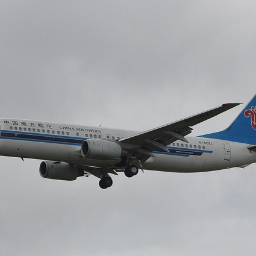

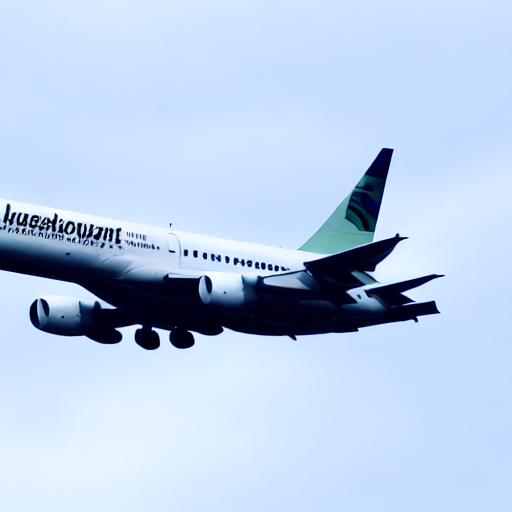

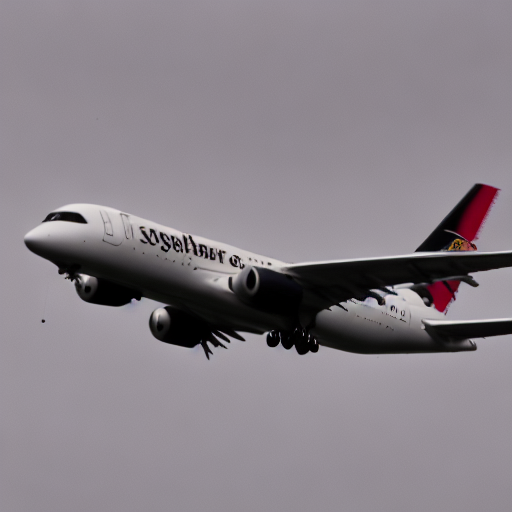

In [13]:
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
origin_images = torch.load(f'all_images.pt')
recon_wo_low_images = torch.load(f'baseline_recons_img2img1.0_1samples.pt')
recon_w_low_images = torch.load(f'baseline_recons_img2img0.85_1samples.pt')
to_pil(origin_images[10]).show()
to_pil(recon_w_low_images[10]).show()
to_pil(recon_wo_low_images[10]).show()